In [69]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_white
from statsmodels.regression.linear_model import OLS
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(12435)


In [70]:
# Load datasets
evs = pd.read_csv('data/replication_archive/tables/EVS_main.csv')
evs_weimar = pd.read_csv('data/replication_archive/tables/evs_weimar.csv')
elections = pd.read_csv('data/replication_archive/tables/elections_2017.csv')

print(f"EVS Main Dataset: {evs.shape[0]} observations, {evs.shape[1]} variables")
print(f"EVS Weimar Dataset: {evs_weimar.shape[0]} observations, {evs_weimar.shape[1]} variables")
print(f"2017 Elections Dataset: {elections.shape[0]} observations, {elections.shape[1]} variables")
print("\nEVS Main - First few rows:")

# Recode state names for better display
state_names = {
    'DE1': 'WEST:\nBaden-Wurttemberg',
    'DE2': 'WEST:\nBavaria',
    'DE3': 'EAST:\nBerlin',
    'DE4': 'EAST:\nBrandenburg',
    'DE5': 'WEST:\nBremen',
    'DE6': 'WEST:\nHamburg',
    'DE7': 'WEST:\nHessen',
    'DE8': 'EAST:\nMecklenburg-Vorpommern',
    'DE9': 'WEST:\nLower Saxony',
    'DEA': 'WEST:\nNorth Rhine-Westphalia',
    'DEB': 'WEST:\nRhineland Palatinate',
    'DEC': 'WEST:\nSaarland',
    'DED': 'EAST:\nSaxony',
    'DEE': 'EAST:\nSaxony-Anhalt',
    'DEF': 'WEST:\nSchleswig-Holstein',
    'DEG': 'EAST:\nThuringia'
}

evs['state_name'] = evs['state'].map(state_names)
evs['f_state'] = evs['state'].astype('category')

# Summary statistics by state
print("Mean Intolerance by State:")
state_summary = evs.groupby('state_name')['intolerance'].agg(['mean', 'count'])
state_summary.sort_values('mean', ascending=False)
evs.head()

EVS Main Dataset: 2075 observations, 20 variables
EVS Weimar Dataset: 2052 observations, 77 variables
2017 Elections Dataset: 11302 observations, 37 variables

EVS Main - First few rows:
Mean Intolerance by State:


,kreise,Distance,closest_camp,unemp,educ,west,female,age,urban_scale,lr,...,prop_jewish25,unemployment33,population25,nazishare33,intolerance,resentment,far_right,state,state_name,f_state
0,-,15.969231,Neuengamme,0.0,5.0,1,0,63.0,6,5.0,...,0.000966,0.129652,0.596945,0.485495,-0.378253,5.883597,0,DEF,WEST:\nSchleswig-Holstein,DEF
1,-,15.969231,Neuengamme,0.0,5.0,1,0,49.0,6,NaN,...,0.000966,0.129652,0.596945,0.485495,0.898075,-2.047545,0,DEF,WEST:\nSchleswig-Holstein,DEF
2,-,15.969231,Neuengamme,1.0,8.0,1,1,28.0,6,NaN,...,0.000966,0.129652,0.596945,0.485495,-0.378253,-5.604500,0,DEF,WEST:\nSchleswig-Holstein,DEF
3,-,15.969231,Neuengamme,1.0,5.0,1,1,53.0,6,5.0,...,0.000966,0.129652,0.596945,0.485495,0.348260,5.711561,0,DEF,WEST:\nSchleswig-Holstein,DEF
4,-,15.969231,Neuengamme,0.0,5.0,1,0,72.0,6,7.0,...,0.000966,0.129652,0.596945,0.485495,0.396214,3.275474,0,DEF,WEST:\nSchleswig-Holstein,DEF


In [71]:
# basic linear regression with statmodels
model = smf.ols('intolerance ~ age + female', data=evs).fit()
print("\nOLS Regression Results:")
print(model.summary())


OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:            intolerance   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.637
Date:                 Mi, 10 Dez 2025   Prob (F-statistic):            0.00979
Time:                        14:04:43   Log-Likelihood:                -2159.8
No. Observations:                2075   AIC:                             4326.
Df Residuals:                    2072   BIC:                             4343.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0971      

In [72]:
# missing value stats
missing_stats = evs.isnull().mean() * 100
print("\nMissing Value Statistics (%):")
print(missing_stats[missing_stats > 0])


Missing Value Statistics (%):
unemp            0.192771
educ             0.240964
lr              33.253012
immigrants07     0.819277
dtype: float64


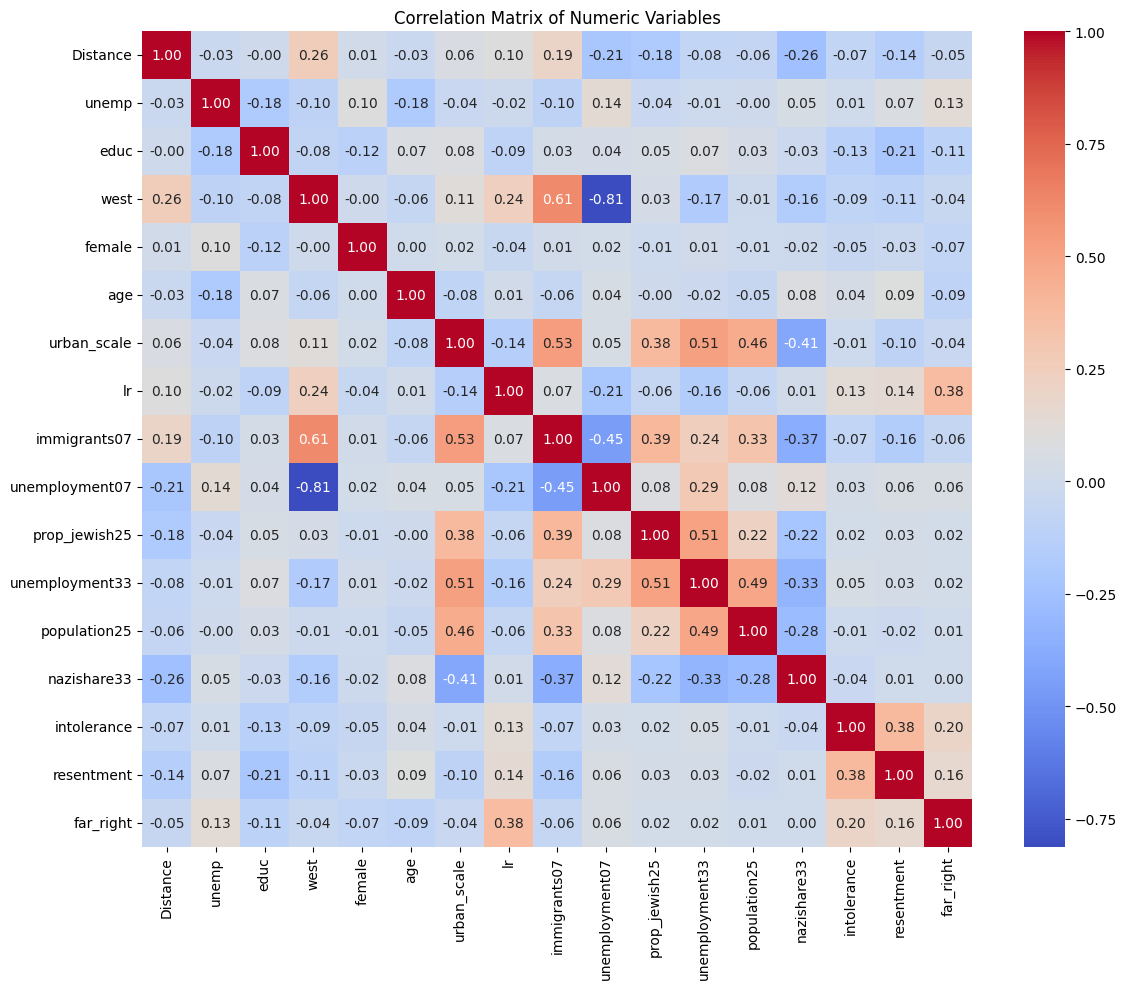

In [73]:
# corrplot from numeric values
numeric_cols = evs.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()

In [74]:
# generate dicts for y and X variables and controls
y = {
    'intolerance': 'Intolerance Score'
}
X = {
    'urban_scale': 'Distance to Nearest Border (km)',
    'age': 'Age',
    'female': 'Female (1=Yes)',
    'educ': 'Education',
    'unemp': 'Unemployed (1=Yes)',
    'Distance': 'Distance to concentration camp (km)',
}
controls = {
   'state': 'State fixed effects (one-hot)',
}

# helper to build design matrix with fixed effects
def build_design_matrix(df, base_features, control_cats):
    X_base = df[base_features].copy()
    if control_cats:
        dummies = []
        for col in control_cats:
            dummy = pd.get_dummies(df[col], prefix=col, drop_first=True)
            dummies.append(dummy)
        if dummies:
            X_base = pd.concat([X_base] + dummies, axis=1)
    return X_base

# select feature/target columns up front and add controls
feature_cols = list(X.keys())
target_cols = list(y.keys())
control_cols = list(controls.keys())
design_matrix = build_design_matrix(evs, feature_cols, control_cols)

# do train test split
X_train_df, X_test_df, y_train, y_test = train_test_split(design_matrix, evs[target_cols], test_size=0.2, random_state=42)

# scale features and keep column names
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train_df),
    columns=X_train_df.columns,
    index=X_train_df.index,
)
X_test = pd.DataFrame(
    scaler.transform(X_test_df),
    columns=X_test_df.columns,
    index=X_test_df.index,
)


# define dict for sklearn models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
models = {
    'OLS': LinearRegression(),
    'RF-Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
  #  'Logistic Regression': LogisticRegression(max_iter=1000),
    'Simple desicion tree': DecisionTreeRegressor(random_state=42),
    'SVM': SVR(kernel='linear'),
}
# imputing missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index,
)
X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index,
)

# fit models
for model_name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} - MSE: {mse:.3f}, R²: {r2:.3f}")

OLS - MSE: 0.528, R²: 0.045
RF-Regressor - MSE: 0.414, R²: 0.251
Gradient boosting - MSE: 0.407, R²: 0.263
Ridge Regression - MSE: 0.528, R²: 0.045
Lasso Regression - MSE: 0.557, R²: -0.007
Simple desicion tree - MSE: 0.669, R²: -0.210
SVM - MSE: 0.671, R²: -0.213


In [75]:
def regression_evaluation(
    models: ModelInput,
    X_test,
    y_test,
    *,
    title: str | None = None,
    control_prefixes: Sequence[str] | None = None,
) -> Dict[str, Dict[str, float]]:
    """Evaluate fitted regressors, plot diagnostics, and summarize metrics."""
    if hasattr(X_test, "columns"):
        feature_names = list(X_test.columns)
        X = np.asarray(X_test.to_numpy())
    else:
        X = np.asarray(X_test)
        feature_names = []
    y = np.asarray(y_test).ravel()
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if y.ndim != 1:
        y = y.ravel()
    if X.shape[0] != y.shape[0]:
        raise ValueError(f'X rows ({X.shape[0]}) and y length ({y.shape[0]}) differ. Ensure matching train/test splits and no NaNs are dropped differently.')
    if not feature_names:
        feature_names = [f"feature_{i}" for i in range(X.shape[1])]

    if isinstance(models, Sequence) and not isinstance(models, RegressorMixin):
        named_models = list(models)
    else:
        named_models = [("model", models)]

    results: Dict[str, Dict[str, float]] = {}
    scalar_metrics: Dict[str, Dict[str, float]] = {}
    feature_importances: Dict[str, np.ndarray | None] = {}
    coef_models: Dict[str, np.ndarray] = {}
    colors = sns.color_palette("tab10", len(named_models))
    color_map: Dict[str, Tuple[float, float, float]] = {}

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    if title:
        fig.suptitle(title)

    cooks_fig, cooks_ax = plt.subplots(figsize=(9, 4))
    qq_quantiles = stats.norm.ppf((np.arange(1, X.shape[0] + 1) - 0.5) / X.shape[0])
    diag_min = y.min()
    diag_max = y.max()

    for idx, (name, model) in enumerate(named_models):
        y_pred = np.asarray(model.predict(X)).ravel()
        residuals = y - y_pred
        n, p = X.shape

        diag_min = min(diag_min, y_pred.min())
        diag_max = max(diag_max, y_pred.max())

        adj_r2 = 1 - (1 - r2_score(y, y_pred)) * (n - 1) / max(n - p - 1, 1)
        X_design = np.c_[np.ones(n), X]
        lm_stat, lm_pvalue, _, _ = het_breuschpagan(residuals, X_design)
        dw = durbin_watson(residuals)
        jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
        vif = [variance_inflation_factor(X, j) for j in range(p)]

        metrics = {
            "r2": r2_score(y, y_pred),
            "adj_r2": adj_r2,
            "explained_variance": explained_variance_score(y, y_pred),
            "rmse": root_mean_squared_error(y, y_pred),
            "mse": mean_squared_error(y, y_pred),
            "mae": mean_absolute_error(y, y_pred),
            "medae": median_absolute_error(y, y_pred),
            "mape": mean_absolute_percentage_error(y, y_pred),
            "breusch_pagan_stat": lm_stat,
            "breusch_pagan_p": lm_pvalue,
            "durbin_watson": dw,
            "jarque_bera_stat": jb_stat,
            "jarque_bera_p": jb_pvalue,
            "vif": dict(enumerate(vif)),
        }
        results[name] = metrics
        scalar_metrics[name] = {k: v for k, v in metrics.items() if np.isscalar(v)}

        XtX_inv = np.linalg.pinv(X_design.T @ X_design)
        leverage = np.einsum("ij,jk,ik->i", X_design, XtX_inv, X_design)
        residual_var = np.maximum(np.mean(residuals**2), 1e-8)
        denom = np.sqrt(np.maximum(1 - leverage, 1e-8)) * np.sqrt(residual_var)
        std_res = residuals / denom
        scale_loc = np.sqrt(np.abs(std_res))
        cooks_d = (std_res**2 * leverage) / ((p + 1) * np.maximum(1 - leverage, 1e-8))

        color = colors[idx % len(colors)]
        color_map[name] = color
        sns.kdeplot(residuals, ax=axes[0, 0], label=name, color=color)
        axes[0, 1].scatter(y_pred, residuals, s=25, alpha=0.75, color=color, label=name)
        axes[0, 2].scatter(y, y_pred, s=25, alpha=0.75, color=color, label=name)

        res_std = np.std(residuals, ddof=1)
        ordered_res = np.sort((residuals - residuals.mean()) / max(res_std, 1e-8))
        axes[1, 0].scatter(qq_quantiles, ordered_res, s=20, alpha=0.75, color=color, label=name)
        axes[1, 1].scatter(y_pred, scale_loc, s=25, alpha=0.75, color=color, label=name)
        axes[1, 2].scatter(leverage, std_res, s=25, alpha=0.75, color=color, label=name)

        markerline, stemlines, baseline = cooks_ax.stem(
            range(len(cooks_d)),
            cooks_d,
            linefmt="-",
            markerfmt="o",
            basefmt=" ",
        )
        plt.setp(markerline, color=color)
        plt.setp(stemlines, color=color)
        markerline.set_label(name)

        importance = None
        if hasattr(model, "feature_importances_"):
            importance = np.asarray(model.feature_importances_, dtype=float)
        elif hasattr(model, "coef_"):
            coef = np.asarray(model.coef_, dtype=float)
            if coef.ndim > 1:
                coef = coef.ravel()
            if coef.size == X.shape[1]:
                coef_models[name] = coef
            importance = np.abs(coef)
        if importance is not None and importance.size == X.shape[1]:
            feature_importances[name] = importance
        else:
            feature_importances[name] = None

    axes[0, 0].set(title="Residual KDEs", xlabel="Residual")
    axes[0, 1].axhline(0, color="red", linestyle="--", linewidth=1)
    axes[0, 1].set(title="Residuals vs Predicted", xlabel="Predicted", ylabel="Residual")
    axes[0, 2].plot([diag_min, diag_max], [diag_min, diag_max], "--", color="black", linewidth=1)
    axes[0, 2].set(title="Actual vs Predicted", xlabel="Actual", ylabel="Predicted")
    axes[0, 0].legend()
    axes[0, 1].legend()
    axes[0, 2].legend()

    min_lim = min(axes[1, 0].get_xlim()[0], axes[1, 0].get_ylim()[0])
    max_lim = max(axes[1, 0].get_xlim()[1], axes[1, 0].get_ylim()[1])
    axes[1, 0].plot([min_lim, max_lim], [min_lim, max_lim], "k--", linewidth=1)
    axes[1, 0].set(xlabel="Theoretical quantiles", ylabel="Ordered values", title="Normal Q-Q Plot")
    axes[1, 0].legend()
    axes[1, 1].set(title="Scale-Location", xlabel="Predicted", ylabel="sqrt(|std residual|)")
    axes[1, 1].legend()
    axes[1, 2].axhline(0, color="red", linestyle="--", linewidth=1)
    axes[1, 2].set(title="Residuals vs Leverage", xlabel="Leverage", ylabel="Std Residual")
    axes[1, 2].legend()

    fig.tight_layout()
    plt.show()

    cooks_ax.axhline(4 / max(X.shape[0] - X.shape[1] - 1, 1), color="red", linestyle="--", linewidth=1)
    cooks_ax.set(title="Cook's Distance", xlabel="Observation", ylabel="Cook's D")
    cooks_ax.legend()
    cooks_fig.tight_layout()
    plt.show()

    metrics_df = pd.DataFrame.from_dict(scalar_metrics, orient="index")
    if not metrics_df.empty:
        if "rmse" in metrics_df.columns:
            metrics_df = metrics_df.sort_values("rmse")
        fig_table, ax_table = plt.subplots(figsize=(1.5 * metrics_df.shape[1], 0.6 * metrics_df.shape[0] + 2))
        normalized_df = metrics_df.copy()
        for col in normalized_df.columns:
            col_min = normalized_df[col].min()
            col_max = normalized_df[col].max()
            if not np.isfinite(col_min) or not np.isfinite(col_max) or abs(col_max - col_min) < 1e-12:
                normalized_df[col] = 0.5
            else:
                normalized_df[col] = (normalized_df[col] - col_min) / (col_max - col_min)
        sns.heatmap(
            normalized_df,
            annot=metrics_df.round(3),
            fmt="",
            cmap="YlGnBu",
            cbar=True,
            ax=ax_table,
        )
        ax_table.set_title("Model Metrics (column-normalized colors)")
        plt.tight_layout()
        plt.show()

        metric_directions = {
            "adj_r2": "max",
            "explained_variance": "max",
            "rmse": "min",
            "mae": "min",
            "mape": "min",
            "breusch_pagan_p": "max",
            "durbin_watson": ("target", 2.0),
            "jarque_bera_p": "max",
            "r2": "max",
        }
        radar_metrics = [col for col in metrics_df.columns if col in metric_directions]
        if radar_metrics:
            radar_df = metrics_df[radar_metrics].copy().astype(float)
            radar_norm = pd.DataFrame(index=radar_df.index, columns=radar_metrics, dtype=float)
            for col in radar_metrics:
                directive = metric_directions[col]
                values = radar_df[col]
                finite_mask = np.isfinite(values)
                if not finite_mask.any():
                    radar_norm[col] = 0.5
                    continue
                vals = values[finite_mask]
                if isinstance(directive, tuple) and directive[0] == "target":
                    target = directive[1]
                    diff = np.abs(vals - target)
                    diff_min = diff.min()
                    diff_max = diff.max()
                    if abs(diff_max - diff_min) < 1e-12:
                        normalized = pd.Series(1.0, index=values.index)
                    else:
                        normalized = 1 - (np.abs(values - target) - diff_min) / (diff_max - diff_min)
                else:
                    col_min = vals.min()
                    col_max = vals.max()
                    direction = directive
                    if abs(col_max - col_min) < 1e-12:
                        normalized = pd.Series(1.0, index=values.index)
                    elif direction == "max":
                        normalized = (values - col_min) / (col_max - col_min)
                    else:
                        normalized = (col_max - values) / (col_max - col_min)
                normalized = normalized.clip(0, 1).fillna(0.5)
                radar_norm[col] = normalized

            angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
            angles += angles[:1]
            fig_radar = plt.figure(figsize=(7, 7))
            ax_radar = fig_radar.add_subplot(111, polar=True)
            for model_name, row in radar_norm.iterrows():
                values = row.tolist()
                values += values[:1]
                color = color_map.get(model_name, None)
                ax_radar.plot(angles, values, label=model_name, color=color)
                ax_radar.fill(angles, values, alpha=0.1, color=color)
            ax_radar.set_xticks(angles[:-1])
            ax_radar.set_xticklabels(radar_metrics)
            ax_radar.set_ylim(0, 1)
            ax_radar.set_yticks([0.25, 0.5, 0.75, 1.0])
            ax_radar.set_yticklabels(["0.25", "0.5", "0.75", "1.0"])
            ax_radar.set_title("Model Metrics Radar (outer = better)")
            ax_radar.legend(loc="upper right", bbox_to_anchor=(1.25, 1.15))
            fig_radar.tight_layout()
            plt.show()

    valid_importances = {k: v for k, v in feature_importances.items() if v is not None}
    if valid_importances:
        normalized_importances = {}
        for model_name, importance in valid_importances.items():
            denom = np.max(importance) if importance.size else 0.0
            if not np.isfinite(denom) or denom < 1e-12:
                normalized_importances[model_name] = np.zeros_like(importance, dtype=float)
            else:
                normalized_importances[model_name] = importance / denom

        reference_model = None
        for ref_name, _ in named_models:
            if ref_name in normalized_importances:
                reference_model = ref_name
                break
        if reference_model is None:
            reference_model = next(iter(normalized_importances))
        ref_imp = normalized_importances[reference_model]
        order_idx = np.argsort(ref_imp)[::-1]
        feature_order = [feature_names[i] for i in order_idx]

        fi_rows = []
        for model_name, importance in normalized_importances.items():
            rows = pd.DataFrame({
                "feature": feature_names[: importance.size],
                "importance": importance,
                "model": model_name,
            })
            fi_rows.append(rows)
        fi_df = pd.concat(fi_rows, ignore_index=True)
        fi_df = fi_df[fi_df["feature"].isin(feature_order)]
        fi_df["feature"] = pd.Categorical(fi_df["feature"], categories=feature_order, ordered=True)
        plt.figure(figsize=(10, max(4, len(feature_order) * 0.4)))
        sns.barplot(data=fi_df, y="feature", x="importance", hue="model")
        plt.title("Normalized Feature Importance by Model")
        plt.xlabel("Normalized importance (per model)")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()


    fixed_effect_rows = []
    if control_prefixes and coef_models:
        coef_model_name, coef_vals = next(iter(coef_models.items()))
        for pref in control_prefixes:
            prefix = f"{pref}_"
            rows = [(fname, coef_vals[idx]) for idx, fname in enumerate(feature_names) if fname.startswith(prefix)]
            if rows:
                df = pd.DataFrame(rows, columns=["feature", "coef"])
                df["group"] = pref
                fixed_effect_rows.append(df)
        if fixed_effect_rows:
            fe_df = pd.concat(fixed_effect_rows, ignore_index=True)
            plt.figure(figsize=(10, max(4, fe_df["feature"].nunique() * 0.35)))
            sns.barplot(data=fe_df, y="feature", x="coef", hue="group", dodge=False)
            plt.axvline(0, color="black", linewidth=1)
            plt.title(f"Fixed-effect coefficients ({coef_model_name})")
            plt.xlabel("Coefficient (scaled features)")
            plt.ylabel("One-hot level")
            plt.tight_layout()
            plt.show()

    return {"metrics": results, "metrics_table": metrics_df}




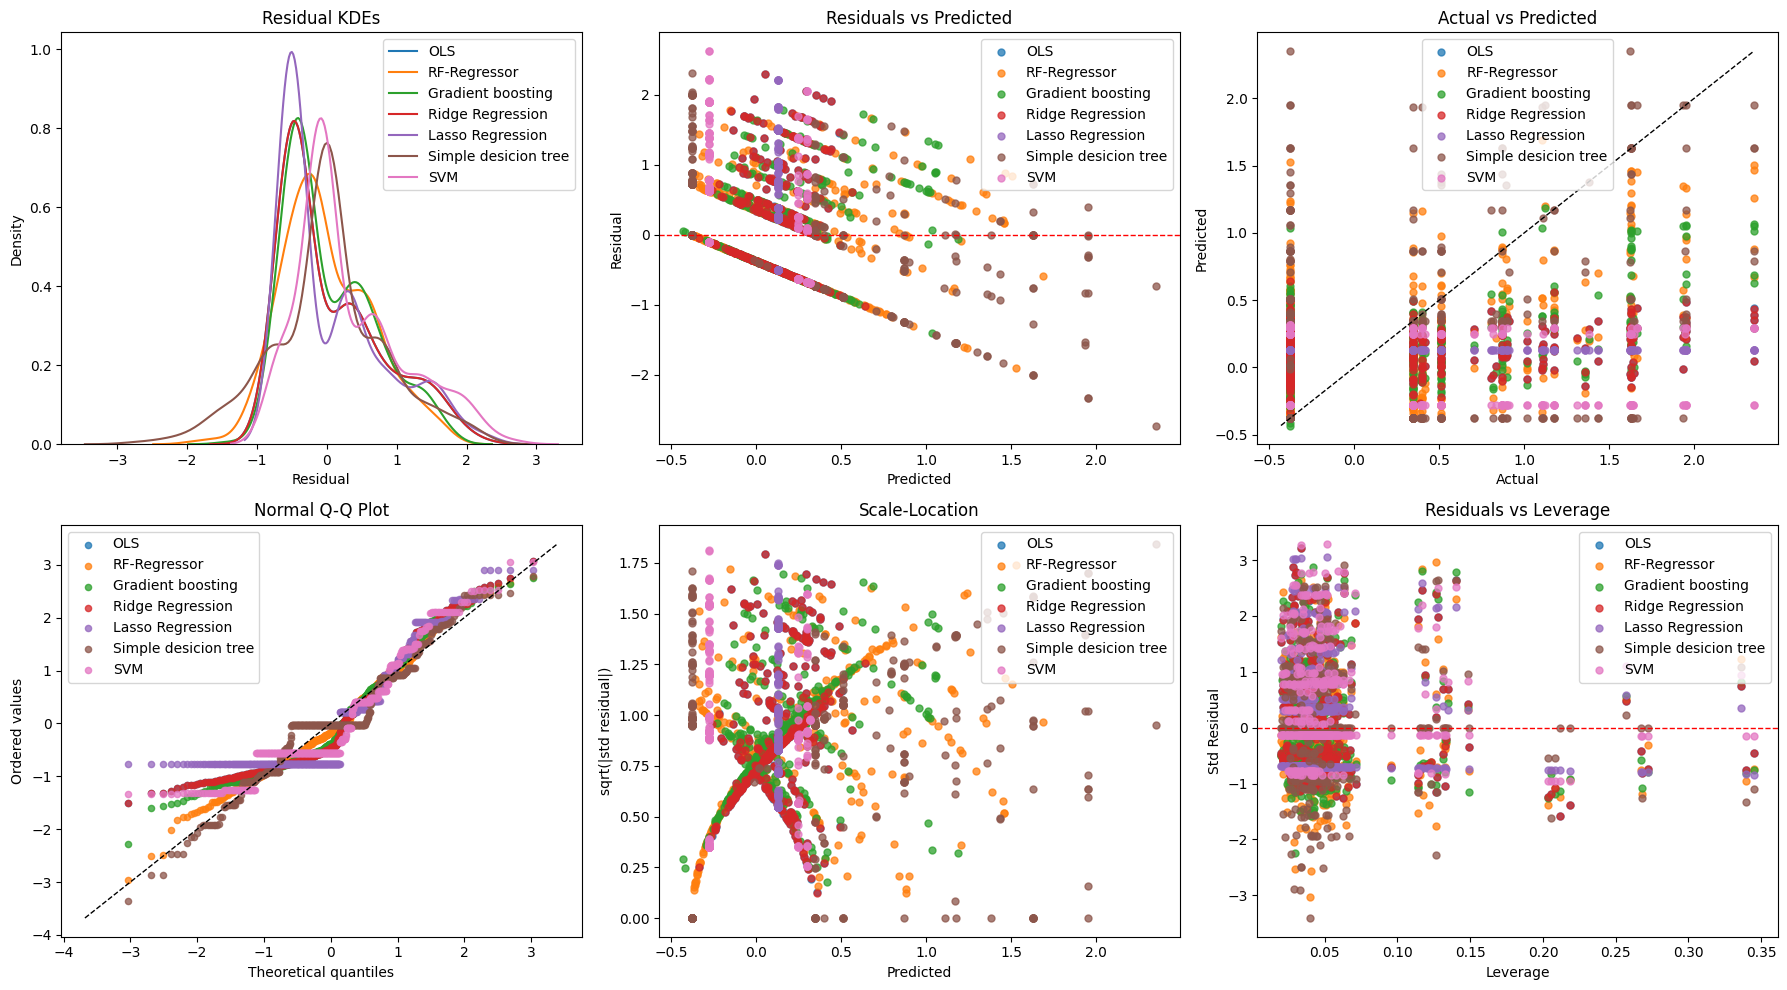

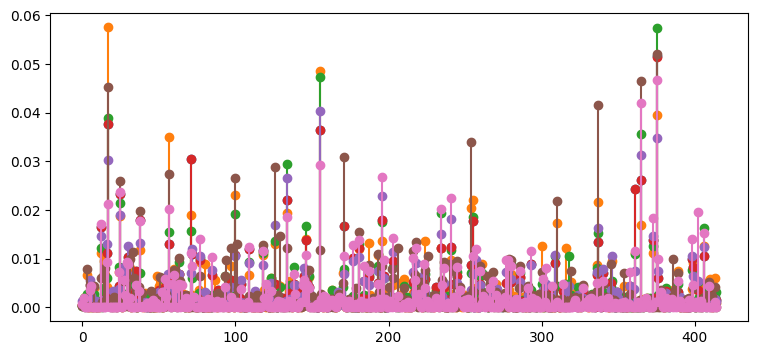

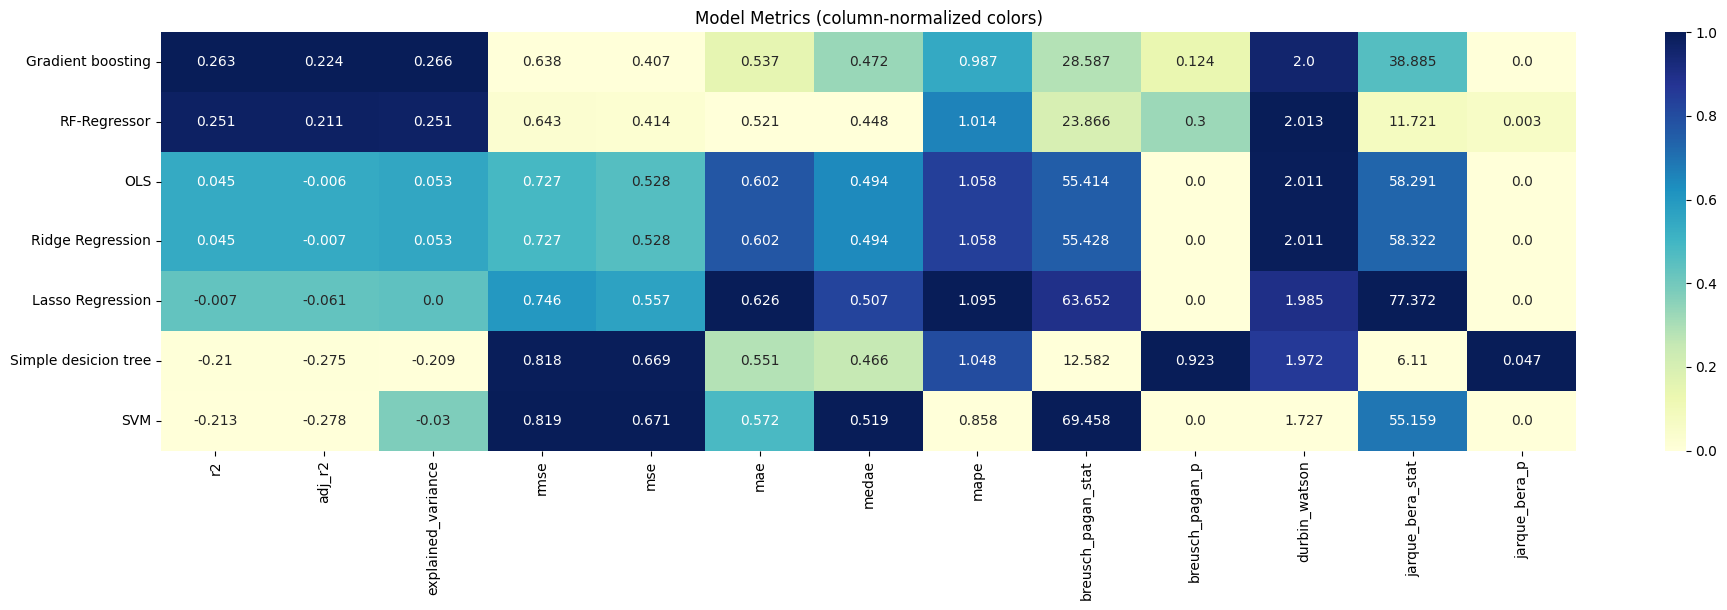

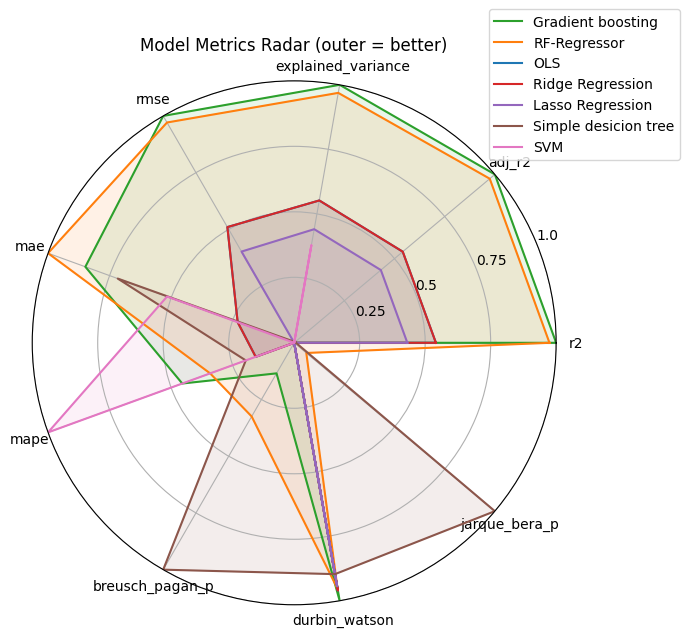

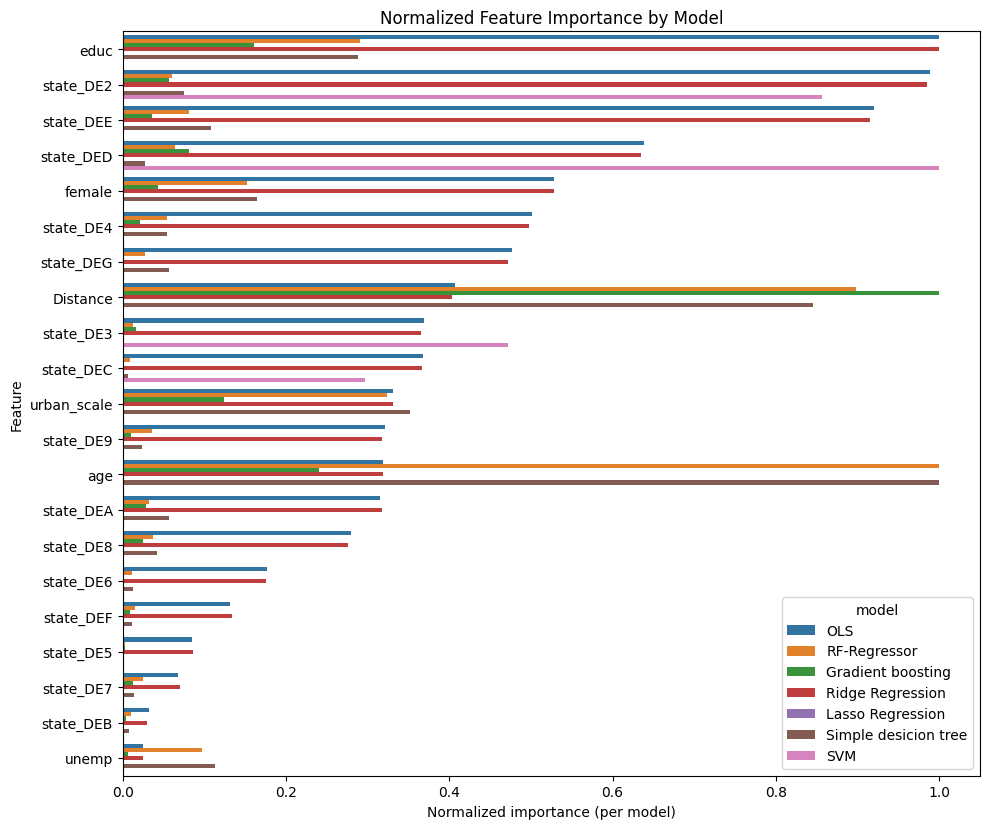

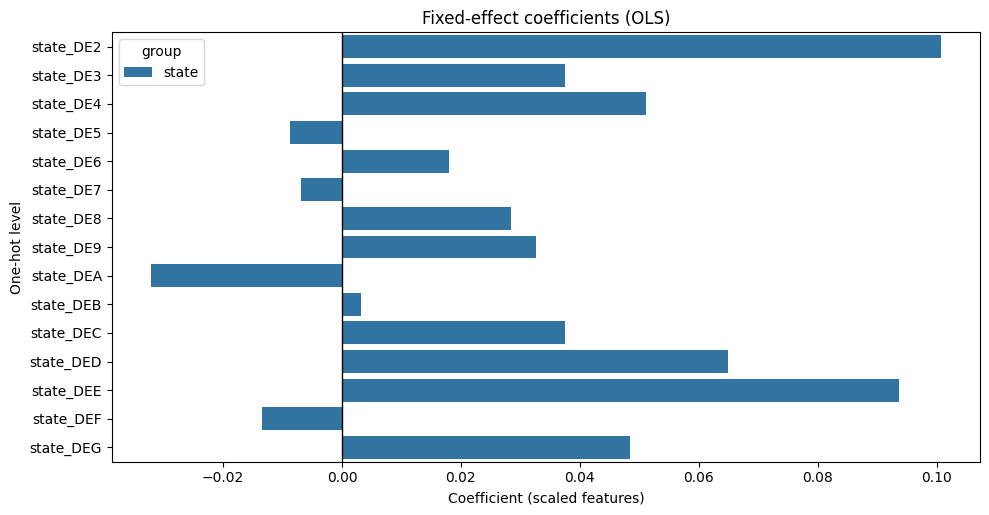

In [76]:
out = regression_evaluation(list(models.items()), X_test, y_test, control_prefixes=control_cols)


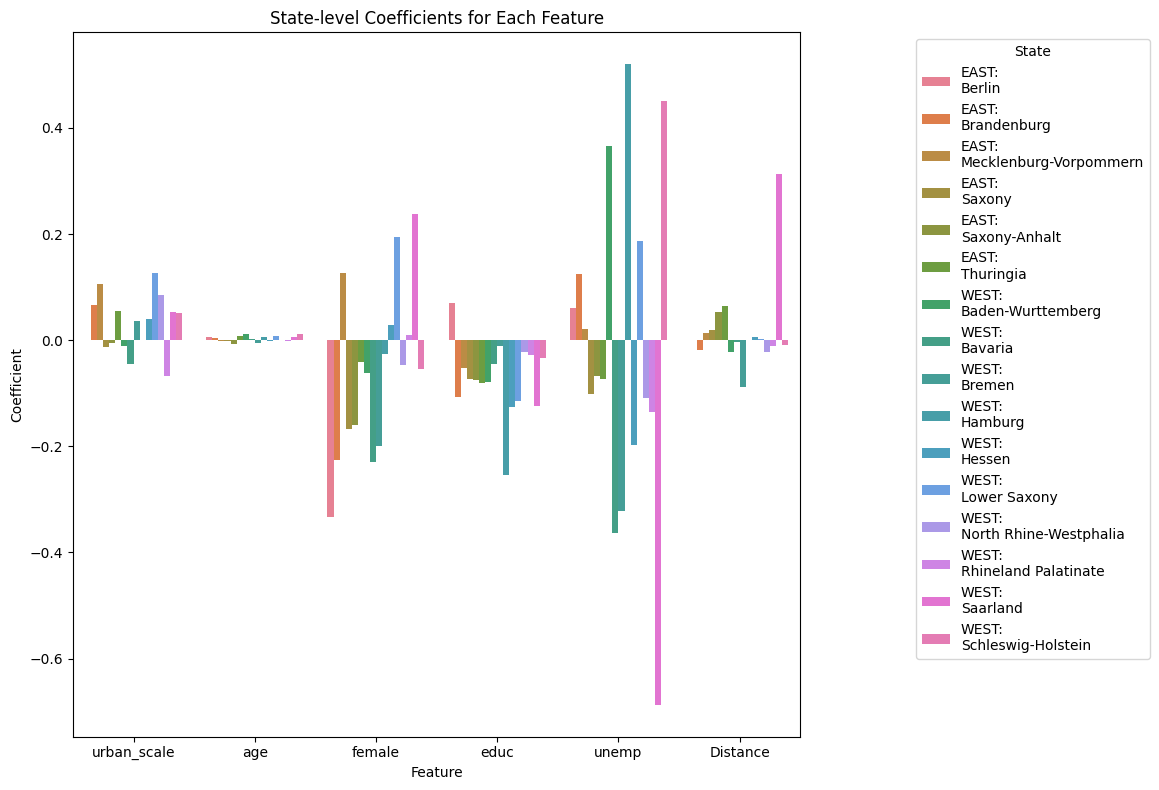

In [97]:
from sklearn.linear_model import LinearRegression

# fit OLS model for each state individual
import statsmodels.api as sm

state_models = {}
state_r2 = {}
state_pvalues = {}
state_stats = []

for state_code, state_df in evs.groupby("state_name"):
    X_state = build_design_matrix(state_df, feature_cols, [])
    y_state = state_df[target_cols]
    
    # impute nas with a state-specific imputer (avoid mismatch with global train columns)
    state_imputer = SimpleImputer(strategy="mean")
    X_state = pd.DataFrame(
        state_imputer.fit_transform(X_state),
        columns=X_state.columns,
        index=X_state.index,
    )
    
    # fit sklearn model for coefficients
    model = LinearRegression()
    model.fit(X_state, y_state)
    state_models[state_code] = model
    
    # fit statsmodels OLS for p-values and R²
    X_state_sm = sm.add_constant(X_state)
    sm_model = sm.OLS(y_state, X_state_sm).fit()
    state_r2[state_code] = sm_model.rsquared
    
    # extract p-values for each feature (skip constant)
    pvals = dict(zip(feature_cols, sm_model.pvalues[1:]))
    state_pvalues[state_code] = pvals
    
    # collect stats for each feature
    for feat in feature_cols:
        state_stats.append({
            'state': state_code,
            'feature': feat,
            'r2': sm_model.rsquared,
            'p_value': pvals.get(feat, np.nan)
        })

# create dataframe for easier analysis
state_stats_df = pd.DataFrame(state_stats)

# compare state-level coefficients
coef_df = []
for state_code, model in state_models.items():
    coefs = model.coef_.ravel()
    for feat, coef in zip(feature_cols, coefs):
        coef_df.append({"state": state_code, "feature": feat, "coefficient": coef})
coef_df = pd.DataFrame(coef_df)

plt.figure(figsize=(12, 8))
sns.barplot(data=coef_df, x="feature", y="coefficient", hue="state")
plt.title("State-level Coefficients for Each Feature")
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.legend(title="State", loc="upper left", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()


State-level R² for Each Feature:
state        EAST:\nBerlin  EAST:\nBrandenburg  EAST:\nMecklenburg-Vorpommern  \
feature                                                                         
Distance          0.083016            0.101376                       0.137101   
age               0.083016            0.101376                       0.137101   
educ              0.083016            0.101376                       0.137101   
female            0.083016            0.101376                       0.137101   
unemp             0.083016            0.101376                       0.137101   
urban_scale       0.083016            0.101376                       0.137101   

state        EAST:\nSaxony  EAST:\nSaxony-Anhalt  EAST:\nThuringia  \
feature                                                              
Distance          0.064074              0.060234          0.109091   
age               0.064074              0.060234          0.109091   
educ              0.064074           

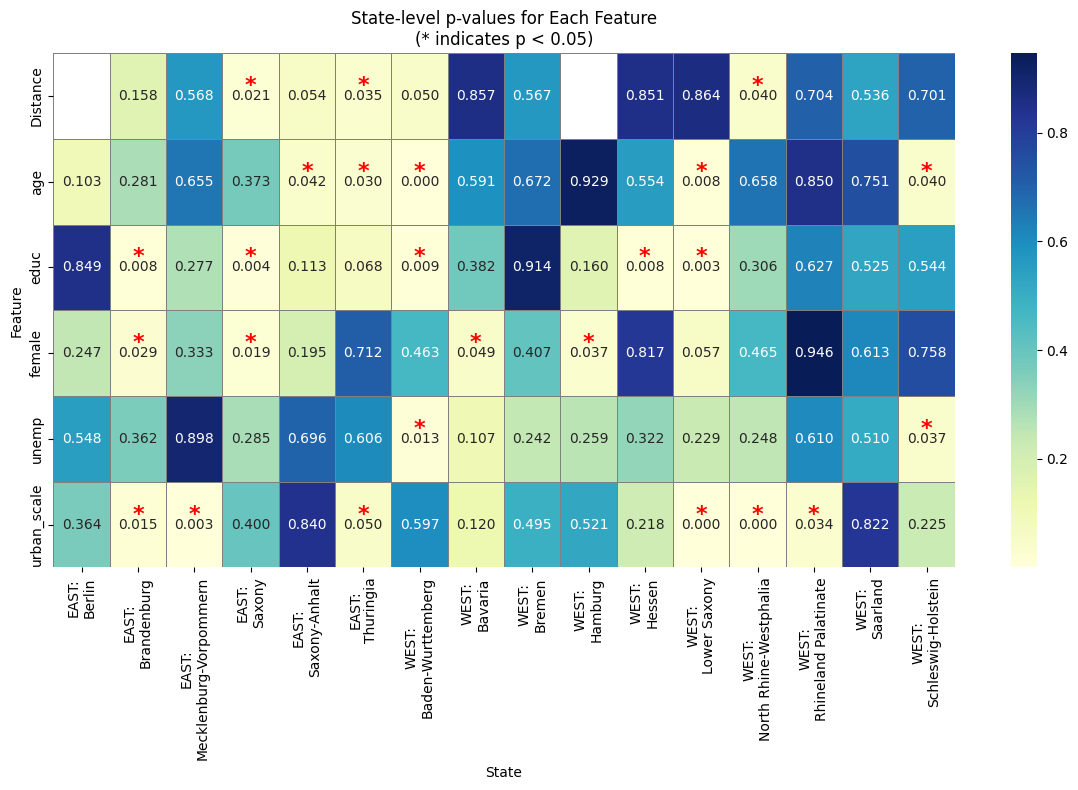

In [103]:
# table from state stats dataframe
pivot_table = state_stats_df.pivot(index="feature", columns="state", values="r2")
print("\nState-level R² for Each Feature:")
print(pivot_table)
print("\nState-level p-values for Each Feature:")
pval_table = state_stats_df.pivot(index="feature", columns="state", values="p_value")
# plot p value table as heatmap, mark p < 0.05
plt.figure(figsize=(12, 8))
mask = pval_table < 0.05
sns.heatmap(pval_table, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, 
            linewidths=0.5, linecolor='gray')

# Add visual markers for significant p-values (p < 0.05)
for i in range(len(pval_table.index)):
    for j in range(len(pval_table.columns)):
        if mask.iloc[i, j]:
            plt.text(j + 0.5, i + 0.5, '*', 
                    ha='center', va='bottom', 
                    color='red', fontsize=16, fontweight='bold')

plt.title("State-level p-values for Each Feature\n(* indicates p < 0.05)")
plt.xlabel("State")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [93]:
evs["state_name"].value_counts()

state_name
EAST:\nSaxony                    314
WEST:\nNorth Rhine-Westphalia    301
EAST:\nSaxony-Anhalt             212
EAST:\nBrandenburg               205
WEST:\nBavaria                   186
WEST:\nBaden-Wurttemberg         180
WEST:\nLower Saxony              135
EAST:\nThuringia                 135
EAST:\nMecklenburg-Vorpommern    102
WEST:\nHessen                     92
EAST:\nBerlin                     58
WEST:\nSchleswig-Holstein         51
WEST:\nRhineland Palatinate       37
WEST:\nHamburg                    30
WEST:\nSaarland                   20
WEST:\nBremen                     17
Name: count, dtype: int64

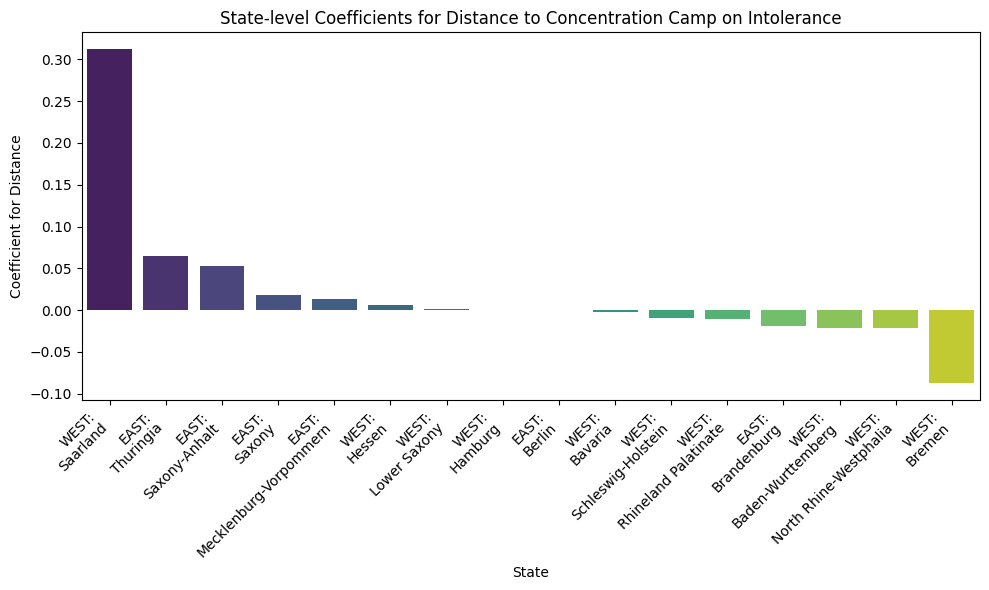

In [94]:
# plot coefficients in descending order for Distance impact on intolerance
distance_coefs = coef_df[coef_df['feature'] == 'Distance'].sort_values(by='coefficient', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=distance_coefs, x='state', y='coefficient', palette='viridis')
plt.title('State-level Coefficients for Distance to Concentration Camp on Intolerance')
plt.xlabel('State')
plt.ylabel('Coefficient for Distance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

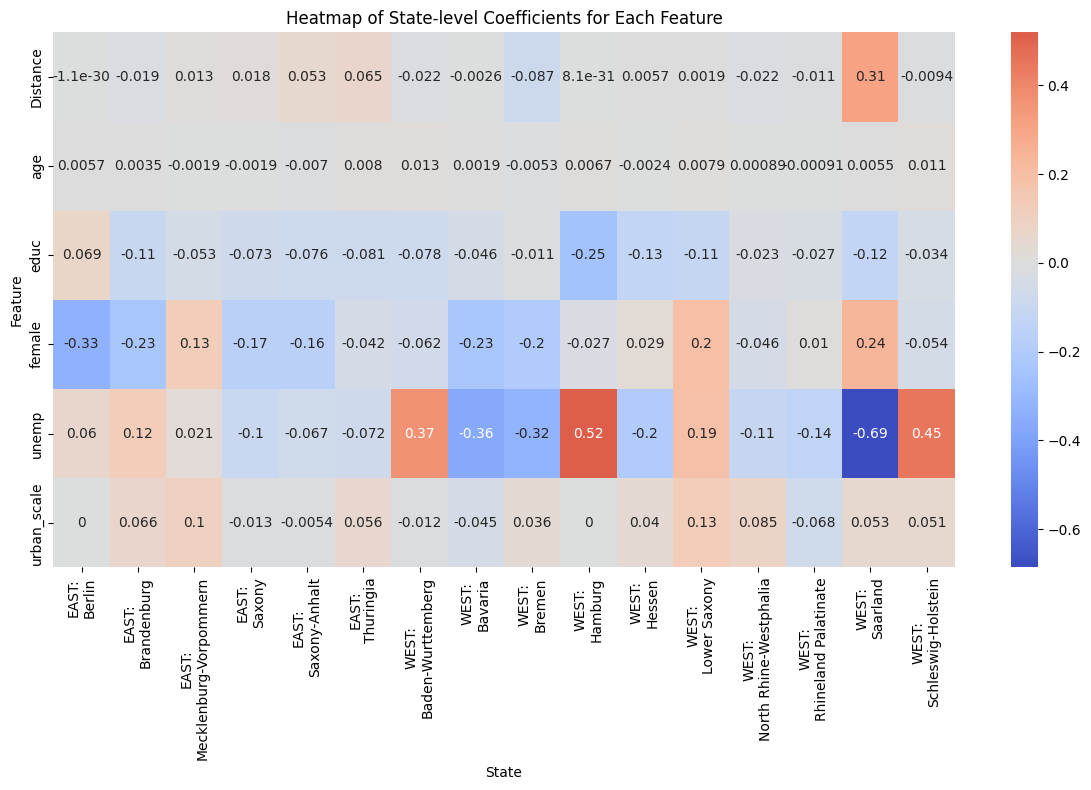

In [95]:
# coefficient heatmap for each state
coef_pivot = coef_df.pivot(index='feature', columns='state', values='coefficient')
plt.figure(figsize=(12, 8))
sns.heatmap(coef_pivot, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of State-level Coefficients for Each Feature')
plt.xlabel('State')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()